In [1]:
# 선형대수, 데이터 전처리
import numpy as np 
import pandas as pd 


# 데이터 전처리, 시각화 등
import os
from PIL import Image
from tqdm import tqdm


# sklearn 모델변경
from sklearn.model_selection import train_test_split


# Keras 딥러닝
import tensorflow as tf 
from keras import Input, Model, optimizers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten,\
                        Dense, Dropout, GlobalAveragePooling2D
from keras.applications.efficientnet import EfficientNetB7
from keras.optimizers import adam_v2 as Adam
from keras.callbacks import ReduceLROnPlateau

print(dir(Adam))

# 데이터의 입력 크기를 전역변수로 설정함
INPUT_SHAPE = (224, 224, 3)  

['Adam', 'NonFusedAdam', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'backend_config', 'keras_export', 'optimizer_v2', 'tf']


### __이미지 사이즈 변경__

#### 변경이유 : 계산 소요시간, 메모리 제한을 피하기위해 이미지 사이즈 변경 후 확인

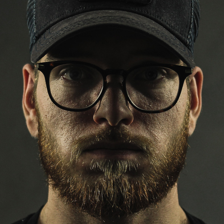

In [2]:
real_face_dir = os.path.join('/kaggle', 'input', 'real-and-fake-face-detection', 'real_and_fake_face', 'training_real')
real_face_image_temp = Image.open(os.path.join(real_face_dir, os.listdir(real_face_dir)[0])).resize((224, 224))
real_face_image_temp

### __데이터 전처리__

#### 데이터 전처리 단계에서는 향후 계산 비용을 고려하여 Normalization만 수행하였음


아래 구분에 따른 이미지 데이터 전처리 방법

(Normalization) 데이터 처리는 RGB값 (Maximum: 255, Minimum: 0)을 사용하여 __MinMaxScale__

(Grayscale conversion) 컬러 그림을 흑백으로 변환 - 채도에 대한 정보가 필요없을 경우 계산의 복잡도를 줄여주지만 현 데이터에서는 적용하지 않음

(Augmentation) 이후 데이터 증폭을 위해 __keras의 ImageDataGenerator__를 사용할 수 있음 (가능한 방법 아래)


    - Shifting : 이미지 픽셀을 수평 또는 수직 방향으로 이동 시킴
    
    - Fliping : 이미지를 수평 또는 수직 축에대햐여 뒤집음
    
    - Rotation : 이미지를 일정한 각도 범위내에서 회전 시킴
    
    - Changing brightness : 이미지의 밝기를 변환시킴
    
    - 그 외 Cropping, Scaling
    
참고 : https://www.section.io/engineering-education/image-preprocessing-in-python/

In [3]:
# 실제, 가짜 얼굴 사진 파일 경로 각각 정의
real_face_dir = os.path.join('/kaggle', 'input', 'real-and-fake-face-detection', 'real_and_fake_face', 'training_real')
fake_face_dir = os.path.join('/kaggle', 'input', 'real-and-fake-face-detection', 'real_and_fake_face', 'training_fake')

# 더미 변수가 들어있는 데이터와 레이블 정의
X_data = np.empty((1,) + INPUT_SHAPE, float)
y_labl = np.empty((1, 1), int)

# 각 사진 파일 Load & resize 이후 데이터와 레이블에 각각 추가 (실제 얼굴 사진)
for real_face in tqdm(os.listdir(real_face_dir)):
    image_normed = np.array([np.array(Image.open(os.path.join(real_face_dir, real_face)).resize((224, 224)))]) / 255
    X_data = np.append(X_data, image_normed, axis=0)
    y_labl = np.append(y_labl, np.array([[0]]), axis=0)

# 더미 데이터 삭제
X_data = np.delete(X_data, 0, axis=0)
y_labl = np.delete(y_labl, 0, axis=0)

# 각 사진 파일 Load & resize 이후 데이터와 레이블에 각각 추가 (가짜 얼굴 사진)
for fake_face in tqdm(os.listdir(fake_face_dir)):
    image_normed = np.array([np.array(Image.open(os.path.join(fake_face_dir, fake_face)).resize((224, 224)))]) / 255
    X_data = np.append(X_data, image_normed, axis=0)
    y_labl = np.append(y_labl, np.array([[1]]), axis=0)

100%|██████████| 960/960 [11:44<00:00,  1.36it/s]


In [4]:
# print(X_data.shape, y_labl.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_labl, test_size=0.2, random_state=42, shuffle=True,
)

print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)

X_train.shape, y_train.shape (1632, 224, 224, 3) (1632, 1)
X_test.shape, y_test.shape (409, 224, 224, 3) (409, 1)


### __딥러닝 모델__

AlexNet 유사모델

In [5]:
# input_shape = (224, 224, 3)
x = Input(shape = INPUT_SHAPE, name='INPUT')


# CONV
conv1 = Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, name='CONV_1')(x)
pool1 = MaxPooling2D((3,3), strides=2, name='POOL_1')(conv1)  # overlapped pooling
lrn1 = BatchNormalization(name='LRN_1')(pool1)

conv2 = Conv2D(filters=256, kernel_size=5, activation='relu', strides=1, padding='same', name='CONV_2')(lrn1)
pool2 = MaxPooling2D((3,3), strides=2, name='POOL_2')(conv2)
lrn2 = BatchNormalization(name='LRN_2')(pool2)

conv3 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_3')(lrn2)
conv4 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_4')(conv3)
conv5 = Conv2D(filters=256, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_5')(conv4)
pool3 = MaxPooling2D((3,3), strides=2, name='POOL_3')(conv5)

f = Flatten()(pool3)
f = Dense(1024, activation='relu', name='FC_1')(f)
f = Dropout(0.2)(f)  # 0.2로 Modification
f = Dense(256, activation='relu', name='FC_2')(f)
f = BatchNormalization(name='LRN_3')(f)
f = Dropout(0.2)(f)
f = Dense(64, activation='relu', name='FC_3')(f)
f = Dropout(0.2)(f)
out = Dense(2, activation='softmax', name='OUTPUT')(f)

model = Model(inputs=x, outputs=out)
model.summary()

2022-05-23 17:00:19.674602: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
CONV_1 (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 26, 26, 96)        0         
_________________________________________________________________
LRN_1 (BatchNormalization)   (None, 26, 26, 96)        384       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 26, 26, 256)       614656    
_________________________________________________________________
POOL_2 (MaxPooling2D)        (None, 12, 12, 256)       0         
_________________________________________________________________
LRN_2 (BatchNormalization)   (None, 12, 12, 256)       1024  

In [6]:
lr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=2, min_delta=0.000001)

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    x=X_train, y=y_train, epochs=2, callbacks=[lr],
    #validation_data=X_test,
)


2022-05-23 17:00:24.243261: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
51/51 [==============================] - 81s 2s/step - loss: 0.9371 - accuracy: 0.5043
Epoch 2/2
51/51 [==============================] - 81s 2s/step - loss: 0.7829 - accuracy: 0.5006


In [7]:
base_model = EfficientNetB7(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Flatten()(x2)
x2 = Dense(128, activation='relu', name='FC_sec_1')(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='relu', name='FC_sec_2')(x2)
x2 = Dropout(0.2)(x2)
out2 = Dense(2, activation='softmax', name='sec_OUTPUT')(x2)

model2 = Model(inputs=base_model.input, outputs=out2)
model2.summary()

258088960/258076736 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_________________________

In [8]:
'''
model2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model2.fit(
    x=X_train, y=y_train, epochs=5, callbacks=[lr],
    #validation_data=X_test,
)
'''

'\nmodel2.compile(\n    optimizer=tf.optimizers.Adam(learning_rate=0.001),\n    loss="sparse_categorical_crossentropy",\n    metrics=["accuracy"],\n)\n\nmodel2.fit(\n    x=X_train, y=y_train, epochs=5, callbacks=[lr],\n    #validation_data=X_test,\n)\n'